
# RISK-MAP: Scoring & Cross-Layer Cascades (Minimal Repro Notebook)

This notebook runs the RISK-MAP scoring pipeline for all robots. It computes:
- Overall and per-layer security scores
- Individual radar charts
- Combined radar across platforms
- Calculates and plots cross-layer vulnerability propagation (Top-3 two-hop cascades)

> **Expected repo layout** (already present): `data/`, `scripts/`, and outputs to `figures/`, `outputs_top3/`.


## Detect repository root

In [2]:

from pathlib import Path

def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        if (p / "data").exists() and (p / "scripts").exists():
            return p
    return start

REPO = find_repo_root()
DATA = REPO / "data"
FIGS = REPO / "figures"
OUT3 = REPO / "outputs_top3"

print("[i] Using repo root:")
print("[i] Subdirs:", [p.name for p in REPO.iterdir() if p.is_dir()])


[i] Using repo root:
[i] Subdirs: ['data', 'figures', 'Information', 'notebooks', 'outputs_top3', 'scripts']


## Quick input checklist

In [3]:

import pandas as pd

need_score = [
    "attacks_vs_defenses_normalised.csv",
    "attack_weights.csv",
]
has_impl = any(p.name.endswith("_implementation_status.csv") for p in DATA.glob("*.csv"))

need_cross_any = ["layer_dependency.csv", "layer_edges_sem.csv"]
need_cross = ["robot_layer_coverage.csv", "attack_families_by_start.csv"]

def check(names):
    return pd.DataFrame([(n, (DATA / n).exists()) for n in names],
                        columns=["file", "exists"]).set_index("file")

print("RISK-MAP scoring inputs:")
display(check(need_score))
print("• Has at least one *_implementation_status.csv?", has_impl)

print("\nCross-Layer cascades inputs: (need one of the first two)")
display(check(need_cross_any))
display(check(need_cross))


RISK-MAP scoring inputs:


,exists
file,
attacks_vs_defenses_normalised.csv,True
attack_weights.csv,True


• Has at least one *_implementation_status.csv? True

Cross-Layer cascades inputs: (need one of the first two)


,exists
file,
layer_dependency.csv,True
layer_edges_sem.csv,True


,exists
file,
robot_layer_coverage.csv,True
attack_families_by_start.csv,True


## 1) Run RISK-MAP scoring

In [6]:

import subprocess, sys

# entry = REPO / "scripts" / "score_RISK_MAP.py"
print("[i] Running:")
proc = subprocess.run([sys.executable, str(entry)], cwd=REPO, capture_output=True, text=True)
print(proc.stdout)
if proc.returncode != 0:
    print(proc.stderr)
    raise SystemExit(f"[!] score_RISK_MAP.py exited with code {proc.returncode}")


[i] Running:
[âœ“]    Digit: RISK_MAP  79.5%  â†’ figures\Digit
[âœ“]   G1_EDU: RISK_MAP  48.9%  â†’ figures\G1_EDU
[âœ“]   Pepper: RISK_MAP  39.9%  â†’ figures\Pepper
[âœ“] Saved per-layer scores CSV
[âœ“] Combined radar saved



### Preview radar figures (per-robot + combined)

→ figures\RISK_MAP_combined_radar.png


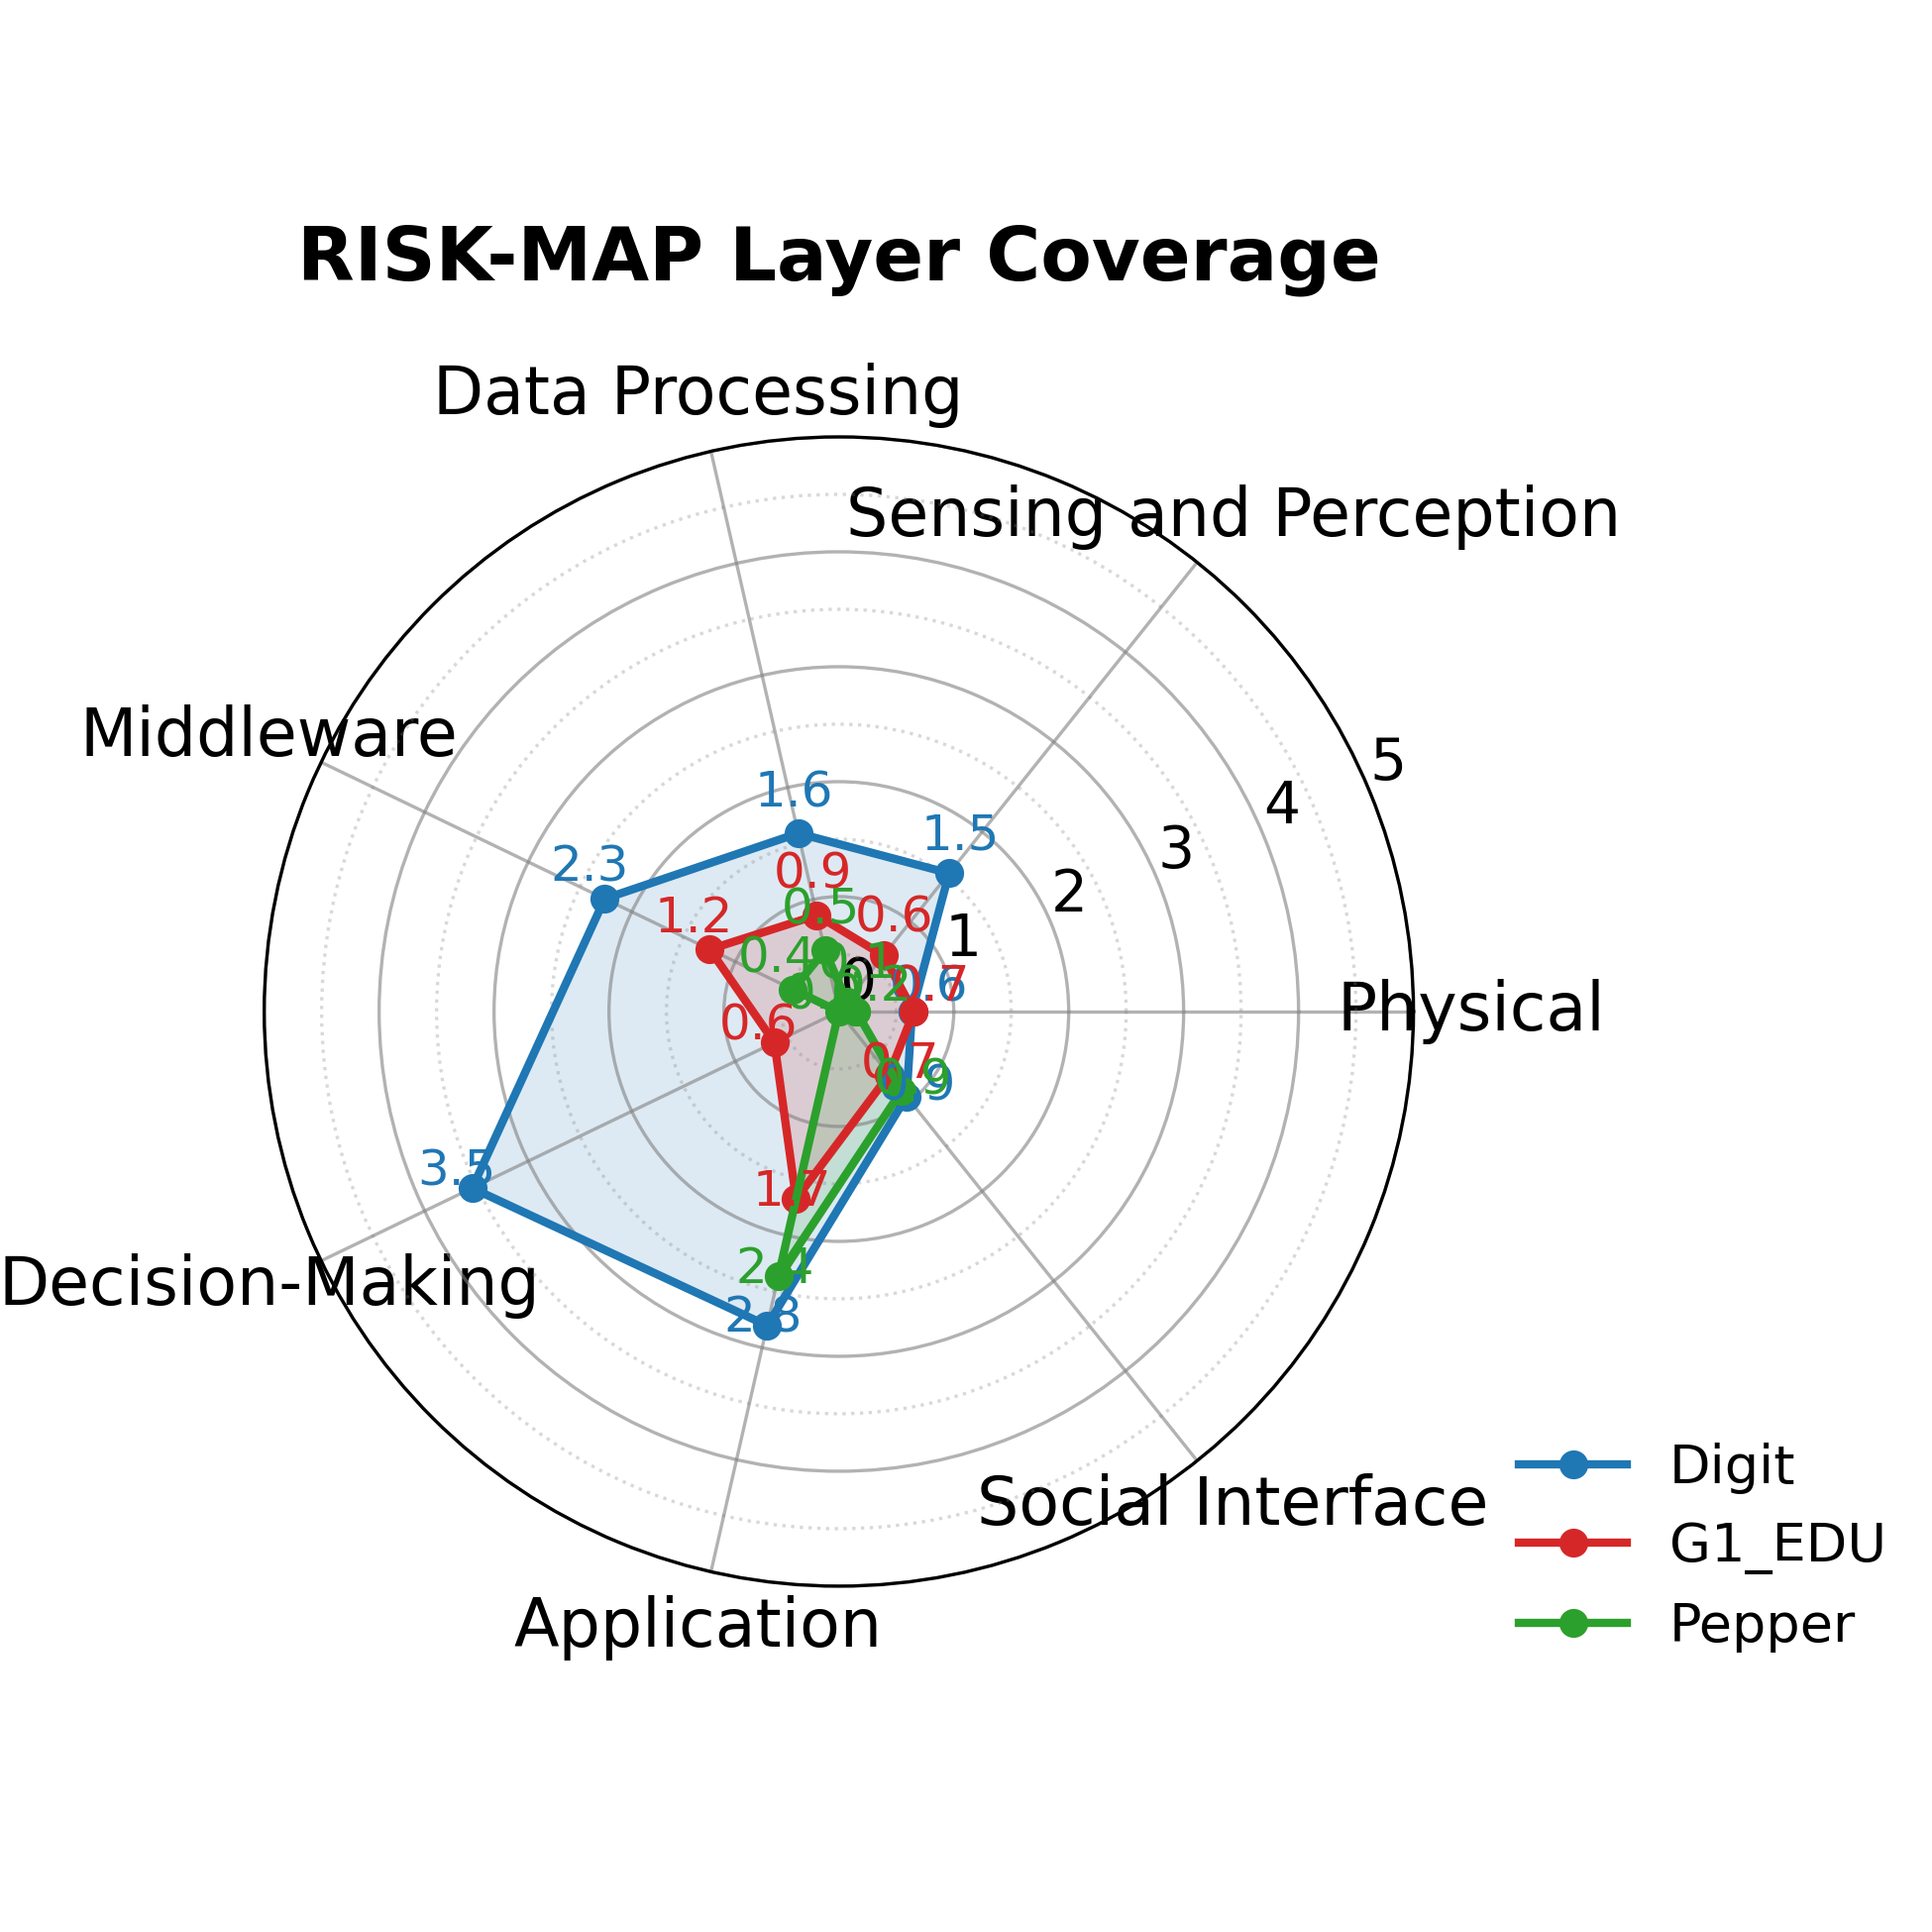

→ figures\Digit\radar.png


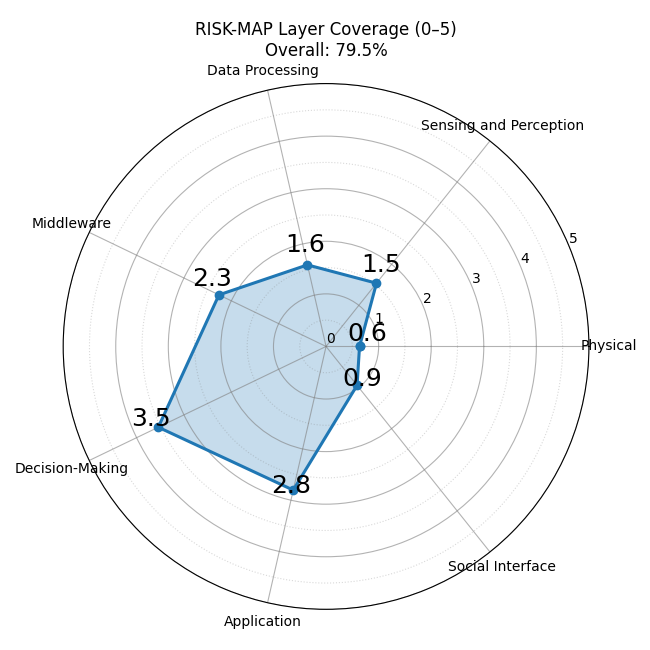

→ figures\G1_EDU\radar.png


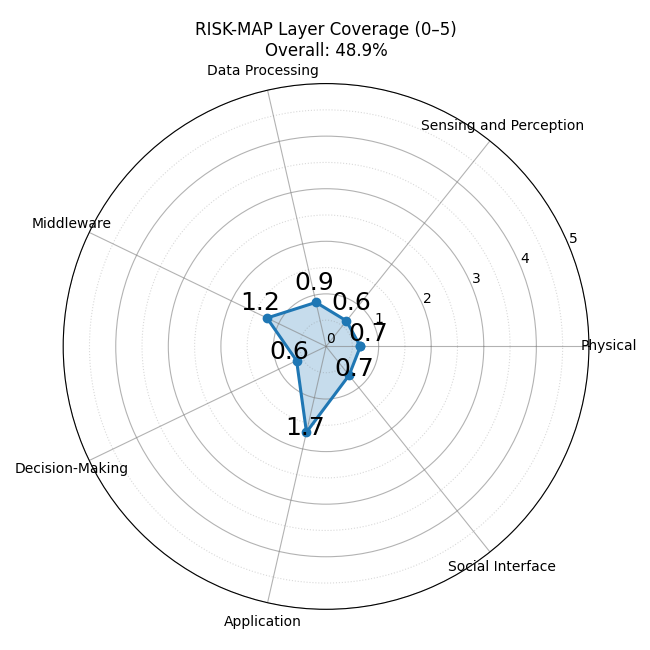

→ figures\Pepper\radar.png


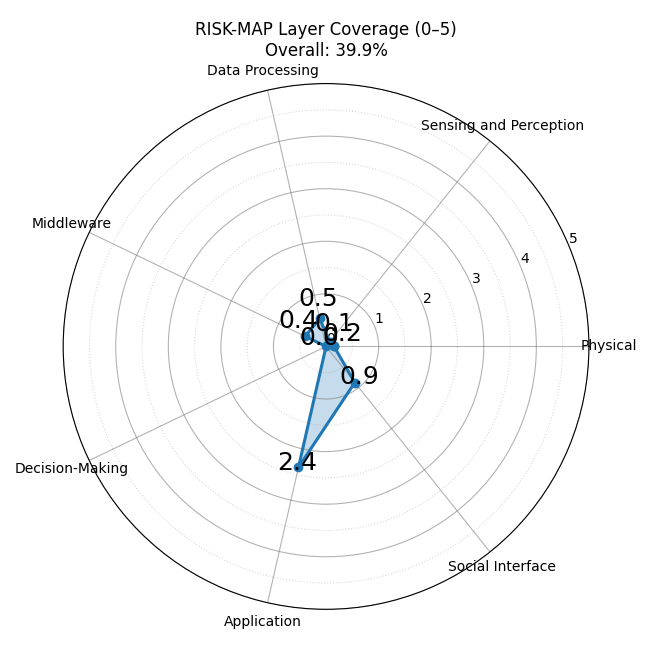

In [7]:

from IPython.display import display, Image

if not FIGS.exists():
    print("[i] No 'figures/' yet.")
else:
    # Combined first (if present)
    combined = list(FIGS.glob("RISK_MAP_combined_radar.png"))
    for p in combined:
        print("→", p.relative_to(REPO))
        display(Image(filename=str(p)))
    # Per-robot radars
    for sub in sorted(FIGS.iterdir()):
        if sub.is_dir():
            png = sub / "radar.png"
            if png.exists():
                print("→", png.relative_to(REPO))
                display(Image(filename=str(png)))


## 2) Cross-Layer vulnerability propagation (Top-3, two-hop cascades)

In [12]:
import subprocess, sys

entry = REPO / "scripts" / "cross_layer_pipeline_top3.py"
print("[i] Running:")
proc = subprocess.run(
    [sys.executable, str(entry)],
    cwd=REPO,
    capture_output=True,
    text=True
)

if proc.returncode == 0:
    print("[✓] Cross-layer propagation finished successfully.")
else:
    print("[!] Error in cross_layer_pipeline_top3.py")
    print(proc.stderr)


[i] Running:
[✓] Cross-layer propagation finished successfully.


### Preview Top-3 outputs

→ outputs_top3\top3_by_robot.csv


,robot,path,CRR,prop_factor,min_coverage,attack_id,code,label_codes
0,Digit,DP>DM>AP,0.112963,0.4514,0.30,Memory-safety overflow DP-A2,"['DP-A2', 'DP-A3', 'DP-A4', 'DP-A1']",DP-A2 +3
1,Digit,S>DP>DM,0.098047,0.4144,0.30,Camera/Depth blinding SP-A2,"['SP-A2', 'SP-A1', 'SP-A3', 'SP-A4', 'SP-A5']",SP-A2 +4
2,Digit,P>S>DP,0.064210,0.2688,0.30,Firmware reflashing P-A1,"['P-A1', 'P-A2', 'P-A4', 'P-A3', 'P-A5']",P-A1 +4
3,G1_EDU,S>DP>DM,0.041026,0.4144,0.45,Camera/Depth blinding SP-A2,"['SP-A2', 'SP-A1', 'SP-A3', 'SP-A5', 'SP-A4']",SP-A2 +4
4,G1_EDU,DP>DM>AP,0.039103,0.4514,0.45,Memory-safety overflow DP-A2,"['DP-A2', 'DP-A3', 'DP-A4', 'DP-A1']",DP-A2 +3
5,G1_EDU,P>S>DP,0.024948,0.2688,0.45,Firmware reflashing P-A1,"['P-A1', 'P-A2', 'P-A4', 'P-A3', 'P-A5']",P-A1 +4
6,Pepper,DP>DM>AP,0.079221,0.4514,0.35,Memory-safety overflow DP-A2,"['DP-A2', 'DP-A4', 'DP-A3', 'DP-A1']",DP-A2 +3
7,Pepper,S>DP>DM,0.077576,0.4144,0.35,Camera/Depth blinding SP-A2,"['SP-A2', 'SP-A1', 'SP-A3', 'SP-A4', 'SP-A5']",SP-A2 +4
8,Pepper,P>S>DP,0.043243,0.2688,0.35,Firmware reflashing P-A1,"['P-A1', 'P-A2', 'P-A4', 'P-A3', 'P-A5']",P-A1 +4


→ outputs_top3\fig_top3_2hop_square.png


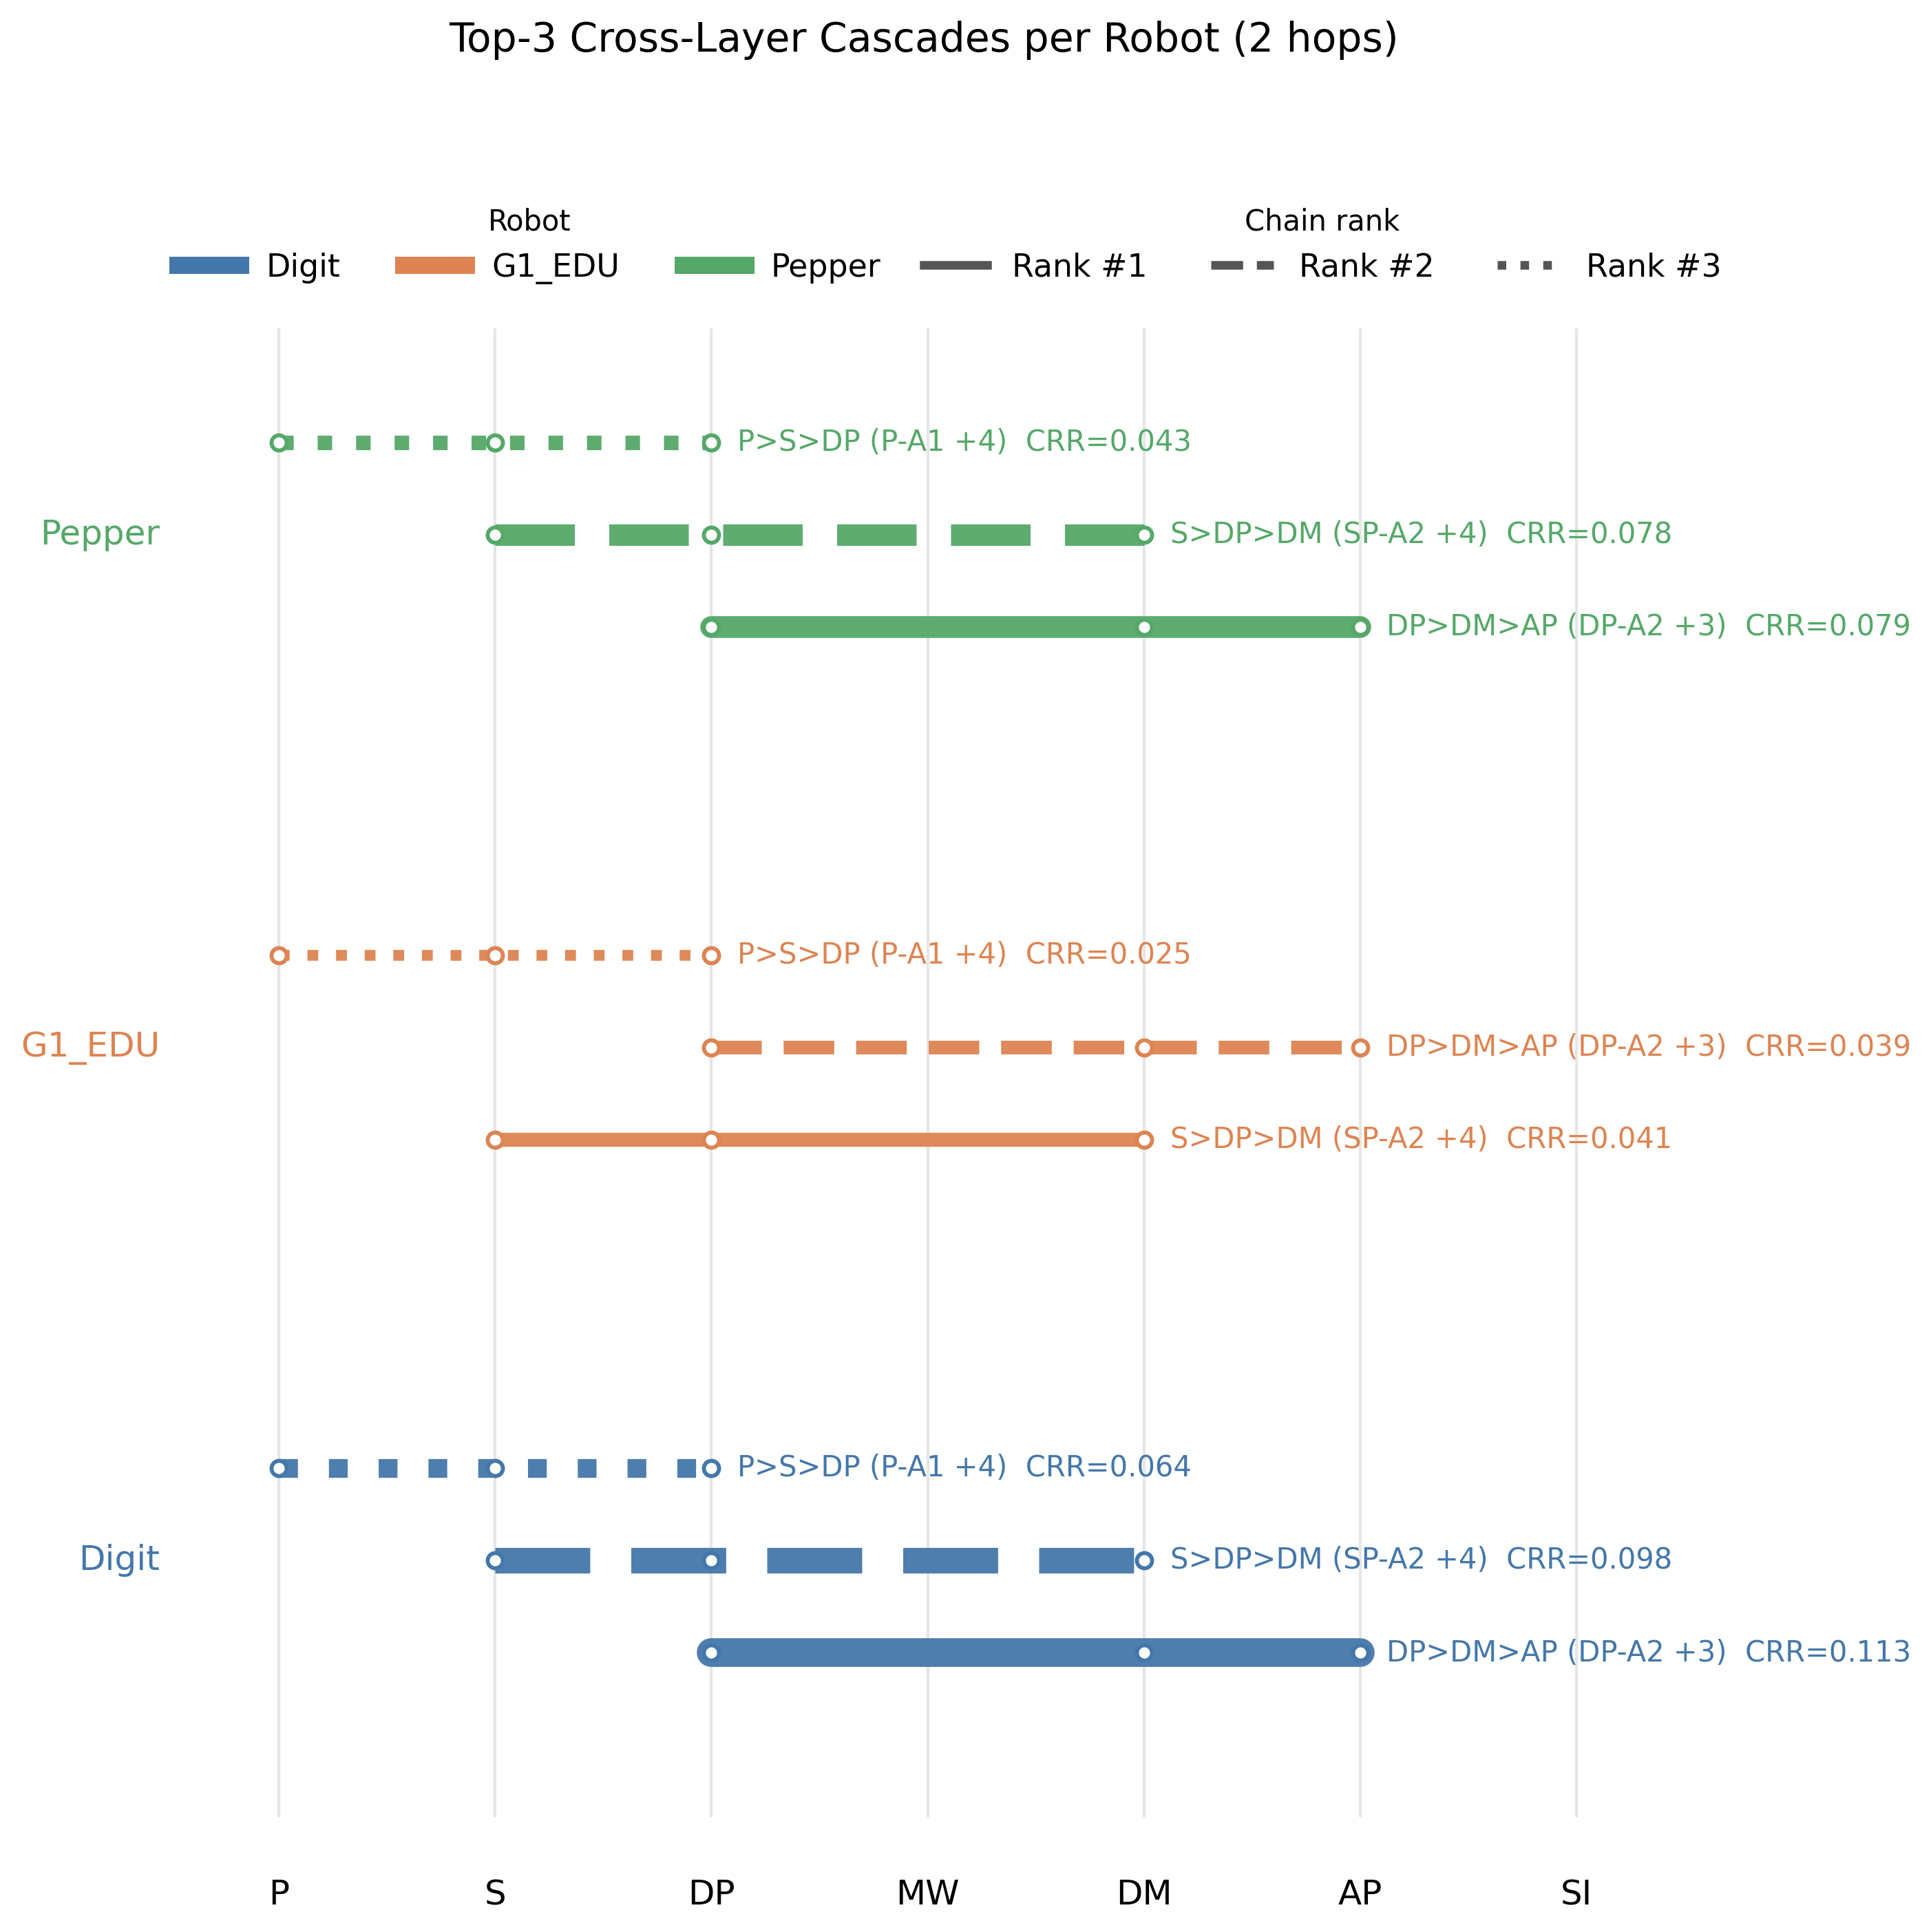

In [11]:

import pandas as pd
from IPython.display import display, Image

tbl = OUT3 / "top3_by_robot.csv"
fig = OUT3 / "fig_top3_2hop_square.png"

if tbl.exists():
    df = pd.read_csv(tbl)
    print("→", tbl.relative_to(REPO))
    display(df.head(20))
else:
    print("[i] Table not found:", tbl)

if fig.exists():
    print("→", fig.relative_to(REPO))
    display(Image(filename=str(fig)))
else:
    print("[i] Figure not found:", fig)
